 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
persistence: 1841.156 RMSE (+/- 0.000)


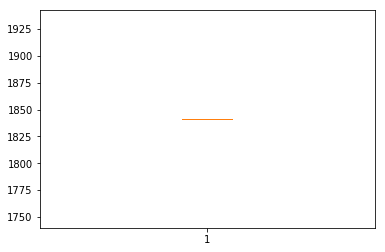

In [5]:
# persistence
from math import sqrt
from numpy import median
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot


import os
os.chdir("C:/Users/LACANAU/Documents/Python Scripts/Machine_Learning_Web")

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

# fit a model
def model_fit(train, config):
    return None

# forecast with a pre-fit model
def model_predict(model, history, config):
    values = list()
    for offset in config:
        values.append(history[-offset])
    return median(values)

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()

series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [12, 24, 36]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('persistence', scores)

Using TensorFlow backend.


 > 1722.922


 > 1694.405


 > 1551.351


 > 1703.519


 > 1704.008


 > 1420.733


 > 1462.014


 > 1411.786


 > 1637.308


 > 1625.065


 > 1698.102


 > 1807.961


 > 1902.044


 > 1540.508


 > 1400.348


 > 1542.162


 > 1593.787


 > 1575.385


 > 1643.157


 > 1615.332


 > 1658.919


 > 1537.696


 > 1560.787


 > 1951.633


 > 1454.129


 > 1573.917


 > 1441.253


 > 1552.886


 > 1433.775


 > 1791.597
mlp: 1606.950 RMSE (+/- 138.437)


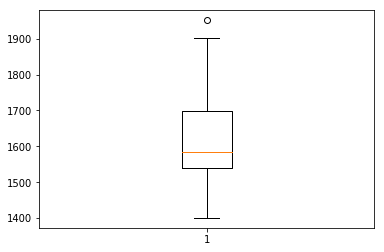

In [6]:
# evaluate mlp
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch = config
    # prepare data
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    # define model
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _ = config
    # prepare data
    x_input = array(history[-n_input:]).reshape(1, n_input)
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()

series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [24, 500, 100, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('mlp', scores)

 > 1580.629


 > 1578.199


 > 1539.112


 > 1482.124


 > 1439.174


 > 1514.601


 > 1521.322


 > 1549.757


 > 1485.565


 > 1580.425


 > 1430.416


 > 1623.179


 > 1508.870


 > 1514.159


 > 1590.758


 > 1610.889


 > 1580.284


 > 1571.369


 > 1570.253


 > 1575.430


 > 1557.237


 > 1544.867


 > 1771.054


 > 1452.013


 > 1597.261


 > 1698.639


 > 1638.974


 > 1601.534


 > 1562.509


 > 1617.310
cnn: 1562.930 RMSE (+/- 70.579)


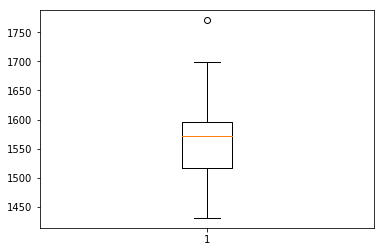

In [7]:
# evaluate cnn
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_filters, n_kernel, n_epochs, n_batch = config
    # prepare data
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    # define model
    model = Sequential()
    model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(n_input, 1)))
    model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, _ = config
    # prepare data
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()

series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [36, 256, 3, 100, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('cnn', scores)

 > 2125.932


 > 2164.178


 > 2080.581


 > 2073.377


 > 2152.388


 > 2124.787


 > 2096.948


 > 2019.589


 > 2022.260


 > 2108.455


 > 2202.072


 > 2055.207


 > 2405.339


 > 2327.207


 > 2170.114


 > 2105.257


 > 2100.038


 > 2127.813


 > 2034.058


 > 2154.098


 > 2075.655


 > 2124.966


 > 1938.838


 > 2062.807


 > 2127.083


 > 2128.427


 > 2052.183


 > 2337.826


 > 2165.359


 > 2087.238
lstm: 2125.003 RMSE (+/- 94.294)


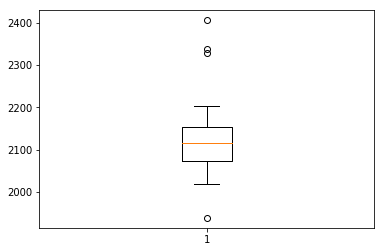

In [8]:
# evaluate lstm
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, n_diff = config
    # prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return correction + yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()

series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [36, 50, 100, 100, 12]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('lstm', scores)

In [9]:
# evaluate cnn lstm
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
    # unpack config
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps
    # prepare data
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(None,n_steps,1))))
    model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(n_nodes, activation='relu'))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps
    # prepare data
    x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()

series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [3, 12, 64, 3, 100, 200, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('cnn-lstm', scores)

 > 1577.474


 > 1428.377


 > 1312.515


 > 1699.315


 > 1923.379


 > 1629.671


 > 1960.529


 > 1352.053


 > 1599.564


 > 1747.992


 > 1950.059


 > 1487.604


 > 1886.148


 > 1475.973


 > 1973.874


 > 1921.770


 > 2458.154


 > 1415.352


 > 2428.259


 > 1607.460


 > 1644.022


 > 2102.298


 > 1886.749


 > 1736.002


 > 2215.578


 > 1347.501


 > 1445.785


 > 1623.478


 > 2326.845


 > 2378.342


 > 1402.338


 > 1465.594


 > 1596.647


 > 2158.588


 > 1822.865


 > 1597.325
convlstm: 1800.492 RMSE (+/- 332.403)


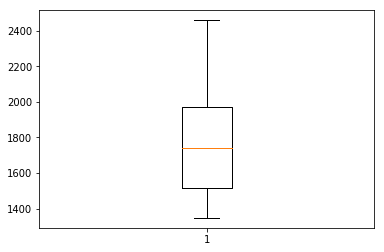

In [10]:
# evaluate convlstm
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

# fit a model
def model_fit(train, config):
    # unpack config
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps
    # prepare data
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, 1, n_steps, 1))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=n_filters, kernel_size=(1,n_kernel), activation='relu', input_shape=(n_seq, 1, n_steps, 1)))
    model.add(Flatten())
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps
    # prepare data
    x_input = array(history[-n_input:]).reshape((1, n_seq, 1, n_steps, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()

series = read_csv('monthly-car-sales.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
# define config
config = [3, 12, 256, 3, 200, 200, 100]
# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('convlstm', scores)